In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import os
import sys
from collections import defaultdict
sys.path.append("../../../code/statistical_analysis/extinction_analysis/")
from simulator import Simulator, ExtinctionOrder

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=40, use_memory_fs=False)

import seaborn as sns

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import auc
import seaborn as sns
import scipy.stats as stats

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
working_dir = f"../../../data/statistical_analysis/extinction_analysis/"
do_weighted = True
weighted_str = f"{'un' if not do_weighted else ''}weighted"

order_to_outdir = {"polyploids_first": f"{working_dir}full_polyploids_first_extinction_on_{weighted_str}_networks/",
                   "diploids_first": f"{working_dir}full_diploids_first_extinction_on_{weighted_str}_networks/",
                   "random": f"{working_dir}full_random_extinction_on_{weighted_str}_networks/"}
networks_metadata_path = "../../../data/networks/networks_metadata.csv"

robustness_data_path = f"{working_dir}robustness_data.csv"

In [3]:
def get_network_id(path):
    components = path.split("/")
    nt = components[-2]
    ni = int(components[-1].replace(".csv",""))
    return nt,ni

non_mono_networks = defaultdict(list)
order_to_data = {}
for order in order_to_outdir:
    outdir = order_to_outdir[order]
    data = pd.concat([pd.read_csv(f"{outdir}{p}") for p in os.listdir(outdir) if p.endswith(".csv")])
    data[["network_type", "network_index"]] = data.parallel_apply(lambda rec: get_network_id(rec.network_path), axis=1, result_type="expand")
    data = data.sort_values(["network_type", "network_index", "simulation_ind", "global_iter"])
    agg_data_by_net = data.groupby(["network_type", "network_index", "simulation_ind"])
    
    for group in agg_data_by_net.groups.keys():
        group_data = agg_data_by_net.get_group(group)
        x_data, y_data = group_data.p_extinct_row, group_data.p_remaining_col
        if not (x_data.round(2).is_monotonic_increasing) or not (y_data.round(2).is_monotonic_decreasing):
            non_mono_networks[order].append(group)

    order_to_data[order] = data

In [4]:
for order in non_mono_networks:
    print(order, len(non_mono_networks[order]))
set(non_mono_networks["polyploids_first"])&set(non_mono_networks["diploids_first"])&set(non_mono_networks["random"])

set()

In [5]:
def get_robustness_measures(df: pd.DataFrame) -> pd.Series:
    robustness_df = df.groupby(["network_type", "network_index", "simulation_ind"]).parallel_apply(lambda df: auc(df.p_extinct_row, df.p_remaining_col)).reset_index().rename(columns={0: "robustness"})
    robustness_df["num_cascades"] = df.groupby(["network_type", "network_index", "simulation_ind"]).cascade_ind.apply(lambda l: len(set(l))).values
    return robustness_df

order_to_robustness_data = {}
order_to_agg_robustness_data = {}
for order in order_to_data:
    robustness_data = get_robustness_measures(df=order_to_data[order])
    order_to_robustness_data[order] = robustness_data
    agg_robustness_df = robustness_data.groupby(["network_type", "network_index"]).robustness.mean().reset_index().rename(columns={"robustness": f"{order}_robustness"})
    order_to_agg_robustness_data[order] = agg_robustness_df

joined_robustness_data = (order_to_agg_robustness_data["polyploids_first"].merge(order_to_agg_robustness_data["diploids_first"], 
                                                                             on=["network_type", "network_index"])).merge(order_to_agg_robustness_data["random"],  
                                                                                                                          on=["network_type", "network_index"])

# assert legality of robustness values
for col in joined_robustness_data.columns:
    if "robustness" in col:
        assert(min(joined_robustness_data[col]) >= 0)
        assert(max(joined_robustness_data[col]) <= 1)

In [6]:
networks_metadata = pd.read_csv(networks_metadata_path)[["network_type", "network_index", "num_plants", "num_pollinators",
                                                          "num_polyploids", "num_diploids", "num_classified",
                                                         "pd", "is_polyploid_poly_frac", "is_polyploid_missing_frac"]]
final_robustness_data = joined_robustness_data.merge(networks_metadata, on=["network_type", "network_index"], how="left")
final_robustness_data.to_csv(robustness_data_path)
final_robustness_data.isna().sum() / final_robustness_data.shape[0]

network_type                   0.00000
network_index                  0.00000
polyploids_first_robustness    0.00000
diploids_first_robustness      0.00000
random_robustness              0.00000
num_plants                     0.00000
num_pollinators                0.00000
num_polyploids                 0.00000
num_diploids                   0.00000
num_classified                 0.00000
pd                             0.75817
is_polyploid_poly_frac         0.00000
is_polyploid_missing_frac      0.00000
dtype: float64

# networks for plotting = 306


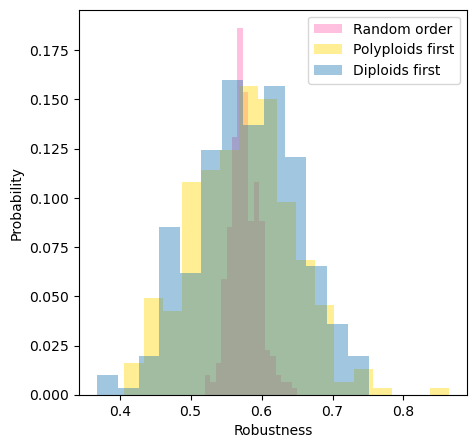

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42
poly_color = "gold" #"tab:orange" # yellow, pink, blue
di_color = "tab:blue"
random_color = "hotpink" #"tab:grey"
alpha = 0.42


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

plot_data = final_robustness_data
print(f"# networks for plotting = {plot_data.shape[0]:,}")
sns.histplot(plot_data.random_robustness, label="Random order", color=random_color, ax=ax, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(plot_data.polyploids_first_robustness, label="Polyploids first", color=poly_color, ax=ax, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(plot_data.diploids_first_robustness, label="Diploids first", ax=ax, color=di_color, stat="probability", alpha=alpha, linewidth=0)

ax.set_xlabel("Robustness")

ax.legend()

# fig.savefig(f"../../../data/figures/fig5.svg")

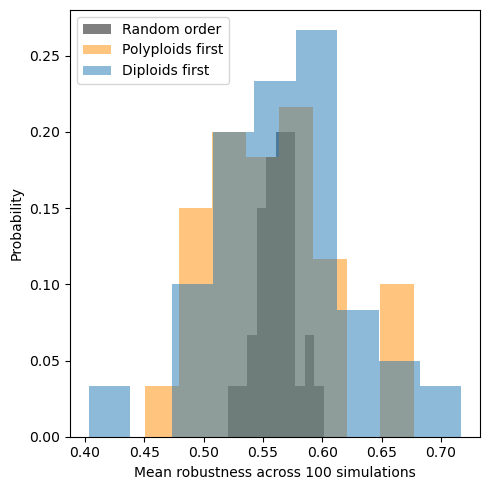

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42
poly_color = "darkorange" #"tab:orange" # yellow, pink, blue
di_color = "tab:blue"
random_color = "black" #"tab:grey"
alpha = 0.5
min_num_class_members = 5 #10

plot_data = final_robustness_data.loc[(final_robustness_data.num_polyploids > min_num_class_members)&(final_robustness_data.num_diploids > min_num_class_members)]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.histplot(plot_data.random_robustness, label="Random order", color=random_color, ax=ax, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(plot_data.polyploids_first_robustness, label="Polyploids first", color=poly_color, ax=ax, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(plot_data.diploids_first_robustness, label="Diploids first", ax=ax, color=di_color, stat="probability", alpha=alpha, linewidth=0)
ax.legend()
ax.set_xlabel("Mean robustness across 100 simulations")
fig.tight_layout()

fig.savefig(f"../../../data/figures/fig5.jpeg")